## Capsule Network With Dynamic Routings

首先处理python2和3的兼容性问题

In [1]:
from __future__ import print_function,division,unicode_literals

这里,我们将使用matplotlib来绘图

In [2]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

再导入numpy和tensorflow

In [3]:
import numpy as np
import tensorflow as tf

/home/lotuswhl/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## 设置环境参数,使得实验结果可复现

In [4]:
# 重置tensorflow的静态图,这样,可以不用重新启动ipython kernel,就可以恢复初始状态了
tf.reset_default_graph()
# 然后设置固定的随机种子(当然,你也可以改为你自己的)
np.random.seed(42)
tf.set_random_seed(42)

## 首先,我们将会构建基于MNIST的模型
(不用担心,后续会逐渐使用于其他的数据集)

### 准备好MNIST数据集

In [5]:
mnist_path="/home/lotuswhl/datasets/mnist/"

In [6]:
from tensorflow.examples.tutorials.mnist import input_data

In [7]:
mnist=input_data.read_data_sets(mnist_path)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /home/lotuswhl/datasets/mnist/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /home/lotuswhl/datasets/mnist/train-labels-idx1-ubyte.gz
Extracting /home/lotuswhl/datasets/mnist/t10k-images-idx3-ubyte.gz
Extracting /home/lotuswhl/datasets/mnist/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


### 看一下我们MNIST图片

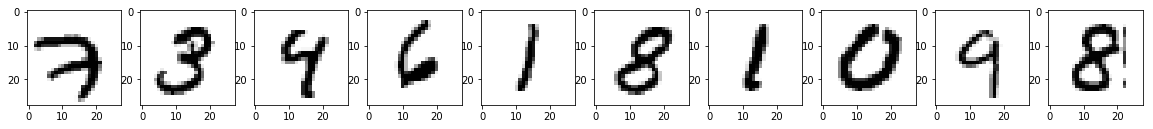

In [8]:
num_samples=10
plt.figure(figsize=(num_samples*2,3))
for i in range(num_samples):
    plt.subplot(1,num_samples,i+1)
    sample_image = mnist.train.images[i].reshape(28,28)
    plt.imshow(sample_image,cmap='binary')
plt.show()

### 与上面对应的标签

In [9]:
print(mnist.train.labels[:num_samples])

[7 3 4 6 1 8 1 0 9 8]


## 接下来我们将构建CapSule Net 来对这些图片进行分类

In [10]:
from IPython.display import Image,display

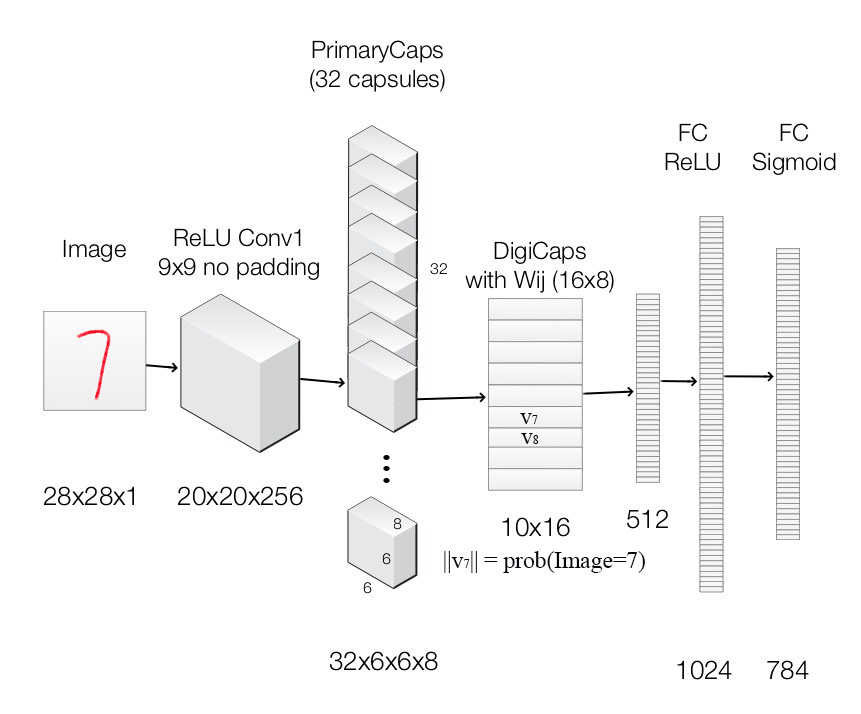

In [11]:
display(Image("./images/capsule_arch.jpg"))

**我们将根据上面的capsule架构构建我们capsule Net**

## 下面开始使用tensorflow一步步完成网络的构建

### 准备输入图片的plcaceholder

In [12]:
image_size=28

In [13]:
x_images = tf.placeholder(shape=[None,image_size,image_size,1],dtype=tf.float32,name="x_images")

### 开始构建 primary capsule 

In [14]:
# 特征图的数量
capsule_primary_num_fmaps=32
# 总的capsule数量（每个capsule由一个8-D向量构成）
capsule_primary_num_capsules=capsule_primary_num_fmaps*6*6 # 也就是总共32*6*6=1152个primary capsule
# primary capsule的向量维数
capsule_primary_num_dimentions=8

* 我们将首先使用卷积网络来进行局部特征的提取，得到初始的局部特征图之后，再构建primary capsule layer
* 在构建primary capsule的时候，我们将利用卷积来对前面提取出的特征图，进行进一步的特征图构建，只是这次，我们将提取的特征图沿着通道channel的轴进行reshape，也就是每8个feature map组成一个capsule map。
* 我们将使用9x9的卷积核，stride为1，不使用padding，我们的输出通道数为256，并且两次卷积的输出通道都是256，第二次卷积的卷积核为9x9，但stride变为2
* 注意计算，第一次卷积输出256个20x20的特征图，第二次卷积输出256个6x6的特征图
* 我们将在第二层卷积网络输出256个6x6特征图，并将其转换为256=32x8 ----> 32个capsule map，也就是每一张8维向量构建成的特征图都将由6x6个8-D capsule构成。
* 当然，我们也可以反向来看，假设我们需要N维capsule，capsule map M个，那么第二层卷积输出通道则为NxM

In [15]:
conv1_params={
    "filters":256,
    "kernel_size":9,
    "strides":1,
    "padding":"valid",# 注意在tensorflow中valid表示no-padding
    "activation":tf.nn.relu
}
conv2_params={
    "filters":256,
    "kernel_size":9,
    "strides":2,
    "padding":"valid",# 注意在tensorflow中valid表示no-padding
    "activation":tf.nn.relu
}

In [16]:
# 根据前面已经构建好的参数，来建立卷积layer
conv1_layer = tf.layers.conv2d(x_images,name="conv1_layer",**conv1_params)
conv2_layer = tf.layers.conv2d(conv1_layer,name="conv2_layer",**conv2_params)

* 根据我们之前的分析，第二层卷积的输出将是6x6x32 个8-D的capsule，并且因为x_images 使用了None，作为batch_size 维的占位符，因此我们上面的输出实际上是(batch_size,6,6,32,8);   
* **然而因为在构建下一层capsule layer也就是digit capsule layer的时候，我们会将primary的所有capsule与后面一层的每一个capsule相连，也就是全连接**   
* 因此，我们可以将primary层的输出进行reshape为(batch_size,primary_capsules,primary_capsule_num_dimentions)这样。

In [17]:
primary_capsule_layer = tf.reshape(conv2_layer,[-1,capsule_primary_num_capsules,capsule_primary_num_dimentions],name="primary_capsule_layer")

#### 接下来构建squash函数
$\operatorname{squash}(\mathbf{s})=\dfrac{\|\mathbf{s}\|^2}{1+\|\mathbf{s}\|} \dfrac{\mathbf{s}}{\|\mathbf{s}\|^2}$
- 有一点值得注意的是因为$\|\mathbf{s}\|$ 可能为0，因此我们不能直接使用tensorflow norm函数，否则我们将会获得一个nan的gradient，因此，我们可以替换计算$\|\mathbf{s}\|$ 的方法为$\|\mathbf{s}\| \approx \sqrt{\sum \limits_i{s_i^2} + \epsilon}$

In [18]:
def squash(s,axis=-1,epsilon=1e-7,name=None):
    with tf.name_scope(name,default_name="squash"):
        s_squared_norm = tf.reduce_sum(tf.square(s),axis=axis,keepdims=True)
        s_norm = tf.sqrt(s_squared_norm+epsilon)
        # 注意等式右边部分，分为两部分，左半部分称之为squash因子，也就是压缩因子，右半部分称之为单位因子，也就是
        # 右半部分将s转为模长为1的单位向量，而左半部分将模长压缩到0-1之间
        squash_factor=s_squared_norm/(1.0+s_squared_norm)
        unit_s = s/s_norm
        return squash_factor*unit_s
        

In [19]:
# 将卷积输出，也就是primary capsule layer的输入进行压缩，压缩为primary capsule layer 的输出
primary_capsule_output=squash(primary_capsule_layer,name="primary_capsule_output")

### 好的，我们已经有了Primary Capsule的输出了，接下来开始构建第二层Capsule也就是Digit Capsule

有一点，我们需要了解的是，从第一层的capsule到第二层的capsule之间有一个转换矩阵W，表面上看起来是将第一层capsule的向量维度转换到第二层capsule的维度，然而，实际上，他所代表的含义韩式很丰富的。这里简单说明一下:实际上，在每一个Primary Capsule到下一层的每一个Digit Capsule之间都有一条连接;其本质意思就是，当前的Primary Capsule预测出或者推测出的Digit Capsule长啥样？也就是形成一种对应的关系。因此，我们后面会发现，对于每一个Primary Capsule（1152个）的矩阵转换输出 与后面10个Digit Capsule 之间会有一个权重链接，实质上是一个分布连接，也就是，当前的Primary Capsule将会赋予它想预测的那个Digit Capsule更高的权重。比如对于一个侧向的鼻子构成的Capsule，它会给下一层表示侧脸的那个Capsule更高的权重。更多的细节与思考，我会整理系列博客来进行探讨。

#### 参数准备，注意下一层的Capsule维度为16，个数为10

In [20]:
capsule_digit_num_capsules = 10
capsule_digit_num_dimentions=16

注意tensorflow的tf.matmul() 不仅仅可以进行矩阵相乘，实际上他还可以处理多维数组的相乘，示例如下：
$\pmatrix{
\mathbf{A} & \mathbf{B}\\
\mathbf{C} & \mathbf{D}
} \times \pmatrix{
\mathbf{H} & \mathbf{I}\\
\mathbf{J} & \mathbf{K}
}=\pmatrix{
\mathbf{AH} & \mathbf{BI}\\
\mathbf{CJ} & \mathbf{DK}
}$

也就是，将矩阵元素element-wise相乘，然后里面的矩阵元素按照矩阵乘法相乘。比如$\mathbf{AH}$就是矩阵相乘。

那么按照之前所说，每一个Primary Capsule与后面每一个Digit Capsule之间都相连，并且在相连之前对于每一对（Primary Capsule，Digit Capsule）（i，j）而言，都有一个转换矩阵$\mathbf{W_{ij}}$

因此，实际上，我们将有1152x10个转换矩阵，并且，每一个Primary Capsule对应10个输出Capsule。比如$\mathbf{u_{j|i}}$

然后我们就可以得到：
$\pmatrix{
\mathbf{W_{1,1}} & \mathbf{W_{1,2}} & \cdots & \mathbf{W_{1,10}} \\
\mathbf{W_{2,1}} & \mathbf{W_{2,2}} & \cdots & \mathbf{W_{2,10}} \\
\vdots & \vdots & \cdots & \vdots \\
\mathbf{W_{1152,1}} & \mathbf{W_{1152,2}} & \cdots & \mathbf{W_{1152,10}} 
} \times \pmatrix{
\mathbf{u_{1}} & \mathbf{u_{1}} & \cdots & \mathbf{u_{1}}\\
\mathbf{u_{2}} & \mathbf{u_{2}} & \cdots & \mathbf{u_{2}}\\
\vdots & \vdots & \cdots & \vdots \\ 
\mathbf{u_{1152}} & \mathbf{u_{1152}} & \cdots & \mathbf{u_{1152}}
} = \pmatrix{
\mathbf{\hat u_{1|1}} & \mathbf{\hat u_{2|1}} & \cdots & \mathbf{\hat u_{10|1}} \\
\mathbf{\hat u_{1|2}} & \mathbf{\hat u_{2|2}} & \cdots & \mathbf{\hat u_{10|2}} \\
\vdots & \vdots & \cdots & \vdots \\
\mathbf{\hat u_{1|1152}} & \mathbf{\hat u_{2|1152}} & \cdots & \mathbf{\hat u_{10|1152}} 
}$

值得注意的是，矩阵乘法中broadcast是不起作用的，因此，对于上式的乘法右边，我们将$\mathbf{u_1}$到$\mathbf{u_1152}$复制了10次，也就是digit capsule的个数次，这里我们将使用tensorflow 的tile函数进行复制（numpy也有这样的函数）

接下来我们需要考虑的是tensor的shape的问题。因为前面的分析并没有加上batch_size这一维，所以，现在我们需要将其加上:
* 首先对于左边的权重矩阵构成的多维数组其维数为(1152,10,16,8),扩展之后(1,1152,10,16,8)，后面在进行计算的时候，我们将会使用tile将其复制batch_size 次
* 对于右边的部分，其shape为(batch_size,1152,10,8,1)

首先，我们来创建可以训练的权重矩阵数组

In [21]:
W_init_sigma = 0.1
W_tensor = tf.random_normal(shape=[1,capsule_primary_num_capsules, 
                                   capsule_digit_num_capsules,
                                   capsule_digit_num_dimentions,
                                   capsule_primary_num_dimentions
                                   ],
                            stddev=W_init_sigma,dtype=tf.float32,name="W_tensor")
W = tf.Variable(W_tensor,name="W")

In [22]:
# 现在，可以根据x的batch_size 维扩展W
batch_size = tf.shape(x_images)[0]
W_tiled = tf.tile(W,[batch_size,1,1,1,1],name="W_tiled")

注意前面的primary_capsule_output 的shape是(batch_size,1152,8).为了能够和W_tiled 相乘，我们将其进行扩展，以得到我们的目标输出（Primary Capsule的capsule向量转换后的输出）

In [23]:
primary_capsule_output_expand = tf.expand_dims(primary_capsule_output,axis=-1,name="primary_capsule_output_expand")

In [24]:
# 上面转换后，我们得到(batch_size,1152,8,1)
# 现在，我们需要为下一层capsule 也就是digit capsule层做扩展
primary_capsule_output_expand_for_digit = tf.expand_dims(primary_capsule_output_expand,axis=2,name="primary_capsule_output_expand_for_digit")

In [25]:
# 现在我们得到的shape是(batch_size,1152,1,8,1)
# 我们将其中的digit维度进行tile 复制 扩展
primary_capsule_output_tiled_digit = tf.tile(primary_capsule_output_expand_for_digit,[1,1,capsule_digit_num_capsules,1,1],name="primary_capsule_output_tiled_digit")

验证一下shape是否正确

In [26]:
W_tiled

<tf.Tensor 'W_tiled:0' shape=(?, 1152, 10, 16, 8) dtype=float32>

In [27]:
primary_capsule_output_tiled_digit

<tf.Tensor 'primary_capsule_output_tiled_digit:0' shape=(?, 1152, 10, 8, 1) dtype=float32>

现在就可以使用tf.matmul 来转换输出了,也就是输出预测向量（next capsule）

In [28]:
primary_capsule_predicts=tf.matmul(W_tiled,primary_capsule_output_tiled_digit,name="primary_capsule_predicts")

In [29]:
primary_capsule_predicts

<tf.Tensor 'primary_capsule_predicts:0' shape=(?, 1152, 10, 16, 1) dtype=float32>

看起来不错！That's what we need!

### 接下来，开始动态路由之旅

首先需要定义一下我们临时辅助变量b，$\mathbf{b_{ij}}$ 用于衡量primary capsule i与 digit capsule j之间的关联强度，也就是是否可以正确的预测。  一开始我们将其设为0，也就是假设一开始primary capsule并不知道自己应该是哪一个digit capsule的组成成分。

In [30]:
b = tf.zeros(shape=[batch_size,capsule_primary_num_capsules,capsule_digit_num_capsules,1,1],name="b_weights",dtype=tf.float32)

接下来使用softmax，将每一个primary capsule的输出权重$\mathbf{b_{ij}}$ 变为一个分布

In [31]:
c = tf.nn.softmax(b,axis=2,name="c_weights")

In [32]:
b

<tf.Tensor 'b_weights:0' shape=(?, 1152, 10, 1, 1) dtype=float32>

In [33]:
c

<tf.Tensor 'c_weights:0' shape=(?, 1152, 10, 1, 1) dtype=float32>

好的，现在我们有了batch_size x 1152 x 10 个权重，其实也就是batch_size x 1152 个primary capsule，他们每一个对10个digit capsule的权重。下面，我们将它与primary_capsule_predicts 相乘，这样我们就得到了，同样多的输出向量，不过各自乘上了一个分布的权重系数。

In [34]:
primary_capsule_weighted_predictes = tf.multiply(c,primary_capsule_predicts,name="primary_capsule_weighted_predictes")

In [35]:
primary_capsule_weighted_predictes

<tf.Tensor 'primary_capsule_weighted_predictes:0' shape=(?, 1152, 10, 16, 1) dtype=float32>

然后，我们知道，上式中10表示下一层的digit capsule的个数，也就是，对这10个digit capsule来说，他们每一个capsule，都接收来自1152 个16维的primary 输出的预测capsule（也可以说是向量）。也就是说其中1152 x 10 x 16 将会产生**【相加】**10 个 16 维的digit capsule，带上batch_size的话，就是batch_size x 1152 x 10 个16维向量，输入到digit capsule层，得到batch_size x 10 个16维的digit capsule。【当然，这些个capsule，最终还需要通过非线性激活函数squash 进行压缩，最后得到digit capsule的输出】

In [36]:
# 计算squash之前的到digit capsule的输入
digit_capsule_weighted_sum_input = tf.reduce_sum(primary_capsule_weighted_predictes,axis=1,keepdims=True,name="digit_capsule_weighted_sum_input")

In [37]:
digit_capsule_weighted_sum_input

<tf.Tensor 'digit_capsule_weighted_sum_input:0' shape=(?, 1, 10, 16, 1) dtype=float32>

然后通过squash函数，得到我们的digit capsule的输出：$\mathbf{V_j}=\operatorname{squash}(\mathbf{S_j})$

In [38]:
digit_capsule_output_round1 = squash(digit_capsule_weighted_sum_input,axis=-2,name="digit_capsule_output_round1")

In [39]:
digit_capsule_output_round1

<tf.Tensor 'digit_capsule_output_round1/mul:0' shape=(?, 1, 10, 16, 1) dtype=float32>

现在，我们对每一个digit capsule都有一个向量输出了，也就是batch_size个样本输出，得到batch_size 个 （10个digit capsule）的输出。 

#### 接下来我们进行一致性路由

首先，需要简单说明的是，这里我们将对两个相同维度的向量，使用它们的dot product来表示这两个向量的相似度。然后我们的目标是计算每一个primary输出向量与每一个下一层capsule向量之间的相似度，也就称之为一致性路由。

In [40]:
# 我们的primary capsule 的输出预测向量
primary_capsule_predicts

<tf.Tensor 'primary_capsule_predicts:0' shape=(?, 1152, 10, 16, 1) dtype=float32>

In [41]:
# 我们的digit capsule的输出向量
digit_capsule_output_round1

<tf.Tensor 'digit_capsule_output_round1/mul:0' shape=(?, 1, 10, 16, 1) dtype=float32>

仔细观察下上面两个多维数组，接下来我们将利用之前利用过的矩阵乘法，来帮助我们计算每一对(primary predict,digit output)(i,j)的dot product。值得注意的是，在矩阵的乘法中，假设我们要计算矩阵A和矩阵B的列向量之间的点积，那么我们可以使用$A^TB$ 来得到，我们将进行思考，并利用好tf.tile来帮助我们完成这一壮举！

In [42]:
# 通过观察可知，我们只需要将digit_capsule_output_round1的第二维扩展为1152，就可以达到维度匹配了
digit_capsule_output_round1_tiled = tf.tile(digit_capsule_output_round1,[1,capsule_primary_num_capsules,1,1,1],name="digit_capsule_output_round1_tiled")

In [43]:
digit_capsule_output_round1_tiled

<tf.Tensor 'digit_capsule_output_round1_tiled:0' shape=(?, 1152, 10, 16, 1) dtype=float32>

现在，我们计算一致性结果了，注意将其中一个矩阵进行转置。

In [44]:
routing_agreement = tf.matmul(primary_capsule_predicts,digit_capsule_output_round1_tiled,transpose_a=True,name="routing_agreement")

In [45]:
routing_agreement

<tf.Tensor 'routing_agreement:0' shape=(?, 1152, 10, 1, 1) dtype=float32>

In [46]:
b

<tf.Tensor 'b_weights:0' shape=(?, 1152, 10, 1, 1) dtype=float32>

根据paper中所说，我们直接将这个一致性结果也就是相似度值加给b就可以了。

In [47]:
b_round2 = tf.add(b,routing_agreement,name="b_round2")

这样我们就得到了第二轮路由的初始权重b了，接下来将会重复一下之前的部分:
* 根据b计算c
* 然后根据c再计算输入的weighted sum
* 然后squash得到第二轮的capsule输出
* 。。。。。。

In [48]:
c_round2 = tf.nn.softmax(b_round2,axis=2,name="c_round2")

In [49]:
# 重新计算 primary 的weighted 输出
primary_capsule_weighted_predictes_round2 = tf.multiply(c_round2,primary_capsule_predicts,name="primary_capsule_weighted_predictes_round2")

In [50]:
# 再计算对每一个digit capsule的输入：也就是所有输入的predict capsule的sum
digit_capsule_weighted_sum_input_round2 = tf.reduce_sum(primary_capsule_weighted_predictes_round2,axis=1,keepdims=True,
                                                        name="digit_capsule_weighted_sum_input_round2")

In [51]:
# 再进行squash得到第二轮round2的digit capsule的输出
digit_capsule_output_round2 = squash(digit_capsule_weighted_sum_input_round2,axis=-2,name="digit_capsule_output_round2")

In [52]:
digit_capsule_output_round2

<tf.Tensor 'digit_capsule_output_round2/mul:0' shape=(?, 1, 10, 16, 1) dtype=float32>

这里，我们采用的是静态图的构建方式，当然你可以选择使用tensorflow的while_loop来实现动态构建，但是比较麻烦，我就没有尝试了（**后续有机会会尝试使用eager来试试**），毕竟这个图也不是很复杂，当然，如果使用动态图肯定可以更好的节省GPU的内存。   当然对于这种方法，你还可以继续往后增加路由的次数。按照以下步骤进行:
* 获取Primary Capsule输出向量
* 获取上一次Digit Capsule的输出向量
* 对Digit Capsule进行tile扩展以便与Primary Capsule计算agreement(相似度值)
* 有了相似度值更新b
* 有了新的b更新c
* 有了新的c重新计算输入向量的分布向量（也就是各自乘上自己的分布值、概率值系数）weighted
* 计算每一个digit capsule的向量输入的weighted的sum
* squash非线性激活函数输出这一轮的digit capsule

In [53]:
primary_capsule_predicts

<tf.Tensor 'primary_capsule_predicts:0' shape=(?, 1152, 10, 16, 1) dtype=float32>

In [54]:
# 上一次digit capsule的输出digit_capsule_output_round2
digit_capsule_output_round2_tiled = tf.tile(digit_capsule_output_round2,[1,capsule_primary_num_capsules,1,1,1],name="digit_capsule_output_round2_tiled")
# tile 之后就可以计算新的agreement
routing_agreement_2 = tf.matmul(primary_capsule_predicts,digit_capsule_output_round2_tiled,transpose_a=True,name="routing_agreement2")
# 有了新的agreement之后更新b
b_round3 = tf.add(b_round2,routing_agreement_2,name="b_round3")
# 计算新的c
c_round3 = tf.nn.softmax(b_round3,axis=2,name="c_round3")
# 计算新的weighted primary 预测向量也就是输出向量
primary_capsule_weighted_predictes_round3 = tf.multiply(c_round3,primary_capsule_predicts,name="primary_capsule_weighted_predictes_round3")
# sum primary capsule维获得新的digit capsule的输入
digit_capsule_weighted_sum_input_round3 = tf.reduce_sum(primary_capsule_weighted_predictes_round3,axis=1,keepdims=True,
                                                        name="digit_capsule_weighted_sum_input_round3")
# squash 得到digit capsule的输出
digit_capsule_output_round3 = squash(digit_capsule_weighted_sum_input_round3,axis=-2,name="digit_capsule_output_round3")

In [55]:
digit_capsule_output=digit_capsule_output_round3

In [56]:
digit_capsule_output

<tf.Tensor 'digit_capsule_output_round3/mul:0' shape=(?, 1, 10, 16, 1) dtype=float32>

#### 接下来我们将进行预测度量

首先，使用安全版本的norm方法来获取输出向量的模长，其模长也就表示存在概率

In [57]:
def safe_norm(s,axis=-1,epsilon=1e-7,name=None,keepdims=False):
    with tf.name_scope(name,default_name="safe_norm"):
        squred_sum = tf.reduce_sum(tf.square(s),axis=axis,keepdims=keepdims)
        s_safe_norm = tf.sqrt(squred_sum+epsilon)
        return s_safe_norm

In [58]:
y_pred_prob = safe_norm(digit_capsule_output,axis=-2,name="y_pred_prob")

In [59]:
y_pred_prob

<tf.Tensor 'y_pred_prob/Sqrt:0' shape=(?, 1, 10, 1) dtype=float32>

In [60]:
y_pred_argmax = tf.argmax(y_pred_prob,axis=2,name="y_pred_argmax")

In [61]:
y_pred_argmax

<tf.Tensor 'y_pred_argmax:0' shape=(?, 1, 1) dtype=int64>

In [62]:
y_pred = tf.squeeze(y_pred_argmax,axis=[1,2],name="y_pred")

In [63]:
y_pred

<tf.Tensor 'y_pred:0' shape=(?,) dtype=int64>

### 好的，现在开始构建训练环境

#### 首先是标签

In [64]:
y_true = tf.placeholder(shape=[None],dtype=tf.int64,name="y_true")

#### margin loss

paper中给出的损失计算公式，是可以在一张图片中检测多个目标的：
$\mathbf{L_c}=\mathbf{T_c} \operatorname{max}(0,\mathbf{m^+}-\|\mathbf{V_c}\|)^2 + \mathbf{\lambda}(1-\mathbf{T_c}) \operatorname{max}(0,\|\mathbf{V_c}\|-\mathbf{m^-})^2$
* 如果输入属于c类，那么Tc为1，否则为0
* paper中$\mathbf{m^+}=0.9$,$\mathbf{m^-}=0.1$,$\mathbf{\lambda}=0.5$

In [65]:
m_plus = 0.9
m_minus = 0.1
lambda_l = 0.5

输入的标签y是其所属类别0,1,2,3等等,我们将其转换为one_hot

In [66]:
T = tf.one_hot(y_true,depth=capsule_digit_num_capsules,name="T")

In [67]:
digit_capsule_output

<tf.Tensor 'digit_capsule_output_round3/mul:0' shape=(?, 1, 10, 16, 1) dtype=float32>

我们首先计算digit capsule的输出的norm，这里我们将使用safe_norm

In [68]:
digit_capsule_output_norm = safe_norm(digit_capsule_output,axis=-2,name="digit_capsule_output_norm",keepdims=True)

In [69]:
digit_capsule_output_norm

<tf.Tensor 'digit_capsule_output_norm/Sqrt:0' shape=(?, 1, 10, 1, 1) dtype=float32>

上面这个值表达了，我们有batch_size个样本，每个样本输出10个norm值（概率值）

然后我们再根据margin loss公式一一计算

In [70]:
present_loss_raw = tf.square(tf.maximum(0.0,m_plus-digit_capsule_output_norm),name="present_loss_raw")
present_loss = tf.reshape(present_loss_raw,shape=[-1,capsule_digit_num_capsules],name="present_loss")

In [71]:
absent_loss_raw = tf.square(tf.maximum(0.0,digit_capsule_output_norm-m_minus),name="absent_loss_raw")
absent_loss = tf.reshape(absent_loss_raw,shape=[-1,capsule_digit_num_capsules],name="absent_loss")

现在可以计算margin loss了

In [72]:
L = tf.add(T*present_loss,lambda_l*(1-T)*absent_loss,name="L")

In [73]:
# do reduce sum and mean over digit capsules L0,L1,...L9
margin_loss = tf.reduce_mean(tf.reduce_sum(L,axis=1),name="margin_loss")

## 准备计算重建损失

按照paper所说，我们将在capsule net之上构建一个三层全连接层，用于恢复图片信息。这个重建层将会根据digit capsule的输出，重建出我们的输入图片。这将会迫使我们的Capsule Net尽可能的保留更多的图片信息，以重建原始图片。同时也提供了一种正则化的手段，也就是防止模型过拟合，帮助模型可以泛化到新的数字。

### MASK

根据paper中的要求，我们将信息从capsule net传递给后面的重建层时，只能传递标签项所对应的capsule向量，如果没有标签也就是test时，则传递预测标签所对应的向量。因此，我们需要一个掩码，来对capsule的输出层进行遮掩操作。

我们首先需要一个placeholder来告知tensorflow我们将基于标签还是预测来进行掩码操作。

In [74]:
is_mask_with_labels = tf.placeholder_with_default(False,shape=(),name="is_mask_with_labels")

In [75]:
# 然后我们使用tensorflow的条件变量来处理我们的重建目标
reconstruct_target_label = tf.cond(is_mask_with_labels,
                                   lambda:y_true,# 如果是真
                                   lambda:y_pred,# 如果是假
                                   name="reconstruct_target_label")

我们发现，上面的`tf.cond`的两个条件目标都是函数，这个与`tf.while_loop`很相似，也就是他们都接受一个函数作为输入，但是他们只会在静态图被构建的开始时被调用，而不是在运行时被调用。这种做法其实可以帮助tensorflow在使用这两个变量之前先eval这两个变量，也就是执行该执行的操作。然而在我们目前的情况下，很明显，在获取reconstrut_target之前，y_true,y_pred就已经eval过了，因此不影响。【但是tensorflow将会将y_true,y_pred作为在获取reconstrut_target之前的依赖条件】，这里reconstruct_target将会获取正确的值不过需要一些限制:
* 首先对于y_pred，无论条件为何都会被eval，但是对训练时来说不会有额外的计算，因为计算margin loss时会计算他，对测试时来说根本不需要重建目标，因此无所谓。
* 对于y_true,令人讨厌的是，无论何时都需要给值，因此在训练时无所谓，因为 会提供，但是对于测试时，我们就需要提供一个空的数组给他，毕竟不会用到他，但是还是需要给他！

关于，掩码，这里可以简单的使用one_hot就可以了

In [76]:
reconstruct_mask = tf.one_hot(reconstruct_target_label,depth=capsule_digit_num_capsules,name="reconstruct_mask")

In [77]:
reconstruct_mask

<tf.Tensor 'reconstruct_mask:0' shape=(?, 10) dtype=float32>

In [78]:
digit_capsule_output

<tf.Tensor 'digit_capsule_output_round3/mul:0' shape=(?, 1, 10, 16, 1) dtype=float32>

我们需要将这个掩码与reconstruct_mask相乘，因此需要reshape一下

In [79]:
reconstruct_mask_reshaped = tf.reshape(reconstruct_mask,shape=[-1,1,capsule_digit_num_capsules,1,1],name="reconstruct_mask_reshaped")

最后可以得到重建输入

In [80]:
reconstruct_input = tf.multiply(reconstruct_mask_reshaped,digit_capsule_output,name="reconstruct_input")

In [81]:
reconstruct_input

<tf.Tensor 'reconstruct_input:0' shape=(?, 1, 10, 16, 1) dtype=float32>

然后我们需要reshape一下输入，flatten一下

In [82]:
reconstruct_input_flattened = tf.reshape(reconstruct_input,
                                         shape=[-1,capsule_digit_num_capsules*capsule_digit_num_dimentions],name="reconstruct_input_flattened")

In [83]:
reconstruct_input_flattened

<tf.Tensor 'reconstruct_input_flattened:0' shape=(?, 160) dtype=float32>

In [84]:
# now we have our decoder input
decoder_input = reconstruct_input_flattened

## 解码器

In [85]:
num_hidden1 = 512
num_hidden2 = 1024
num_output = 28*28

解码器由全连接层构成，前两层使用relu激活函数，最后一层使用sigmoid

In [86]:
with tf.name_scope("decoder"):
    hidden1 = tf.layers.dense(inputs=decoder_input,activation=tf.nn.relu,units=num_hidden1,name="hidden1")
    hidden2 = tf.layers.dense(inputs=hidden1,activation=tf.nn.relu,units=num_hidden2,name="hidden2")
    decoder_output = tf.layers.dense(inputs=hidden2,activation=tf.nn.sigmoid,units=num_output,name="output")


#### 解码器损失

In [87]:
# 使用的简单的square loss
x_flat = tf.reshape(x_images,shape=[-1,num_output],name="x_flat")

In [88]:
squared_distance = tf.square(x_flat-decoder_output,name="squared_distance")

In [89]:
squared_loss = tf.reduce_mean(squared_distance,name="squared_loss")

### 总的损失

总的损失由margin loss 和reconstruct loss组成，并且对reconstruct loss 压缩0.0005，从而使得margin loss起到主要作用。

In [90]:
alpha = 0.0005

In [91]:
total_loss = tf.add(margin_loss,alpha*squared_loss)

### 准确率

In [92]:
correct = tf.equal(y_true,y_pred)

In [93]:
accuracy = tf.reduce_mean(tf.cast(correct,dtype=tf.float32),name="accuracy")

### 训练操作

In [94]:
# 按照paper所说，使用tensorflow的adam optimizer的默认参数
optim = tf.train.AdamOptimizer()

In [95]:
train_op = optim.minimize(loss=total_loss,name="train_op")

### 初始化以及checkpoint保存

In [96]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

## 接下来，可以准备训练啦

In [97]:
train_batch_size = 50
num_epochs = 10
restore_from_checkpoint=False

In [98]:
num_iterations_per_epoch_train = mnist.train.num_examples // train_batch_size
num_iterations_val = mnist.validation.num_examples // train_batch_size
best_val_loss = np.infty
checkpoint_path="./checkpoints/capsule_net_dynamic_routing_checkpoint"

In [99]:
# 配置GPU的使用，不默认占用所有资源。Just be gentle。
config = tf.ConfigProto()
config.gpu_options.allow_growth=True

In [100]:
with tf.Session(config=config) as sess:
    if restore_from_checkpoint and tf.train.checkpoint_exists(checkpoint_path):
        saver.restore(sess,checkpoint_path)
    else:
        sess.run(init)
    
    
    for epoch in range(1,num_epochs+1):
        for iteration in range(1,num_iterations_per_epoch_train+1):
            x_batch,y_batch = mnist.train.next_batch(train_batch_size)
            _,train_loss=sess.run([train_op,total_loss],
                                  feed_dict={
                                      x_images:x_batch.reshape([-1,image_size,image_size,1]),
                                      y_true:y_batch,
                                      is_mask_with_labels:True
                                  })
            print("\repoch:{},iteration:{:5}/{:5},train_loss:{:.5f}"
                  .format(epoch,iteration,num_iterations_per_epoch_train,train_loss),end="")
        
        # 每一个epoch之后执行validation
        loss_values=[]
        accuracy_values=[]
        
        for iteration in range(1,num_iterations_val+1):
            x_batch_val,y_batch_val = mnist.validation.next_batch(train_batch_size)
            loss_val,acc_val = sess.run([total_loss,accuracy],feed_dict={
                x_images:x_batch_val.reshape([-1,image_size,image_size,1]),
                y_true:y_batch_val,
                is_mask_with_labels:False
            })
            loss_values.append(loss_val)
            accuracy_values.append(acc_val)
            print("\rvalidate the model:{}/{}".format(iteration,num_iterations_val),end=" "*15)
        loss_val_mean = np.mean(loss_values)
        accuracy_val_mean = np.mean(accuracy_values)
        print("\rafter {:2} epoch,validation accuracy is:{:.5f} %, val_loss:{:.5f}{}"
              .format(epoch,accuracy_val_mean,loss_val_mean,"[improved]" if best_val_loss>loss_val_mean else ""))
        
        if best_val_loss > loss_val_mean:
            saver.save(sess,checkpoint_path)
            best_val_loss = loss_val_mean
print("Done")

after  1 epoch,validation accuracy is:0.98760 %, val_loss:0.01672[improved]
after  2 epoch,validation accuracy is:0.98940 %, val_loss:0.01093[improved]
after  3 epoch,validation accuracy is:0.99340 %, val_loss:0.00854[improved]
after  4 epoch,validation accuracy is:0.99220 %, val_loss:0.00945
after  5 epoch,validation accuracy is:0.99280 %, val_loss:0.00764[improved]
after  6 epoch,validation accuracy is:0.99100 %, val_loss:0.00902
after  7 epoch,validation accuracy is:0.99220 %, val_loss:0.00787
after  8 epoch,validation accuracy is:0.99340 %, val_loss:0.00729[improved]
after  9 epoch,validation accuracy is:0.99160 %, val_loss:0.00967
after 10 epoch,validation accuracy is:0.99200 %, val_loss:0.00869
Done


## 模型评估

In [101]:
num_iteration_test = mnist.test.num_examples // train_batch_size

In [102]:
with tf.Session(config=config) as sess:
    saver.restore(sess,checkpoint_path)
    loss_test=[]
    acc_test=[]
    for iteration in range(1,num_iteration_test+1):
        x_batch_test,y_batch_test = mnist.test.next_batch(train_batch_size)
        test_loss,test_acc = sess.run([total_loss,accuracy],feed_dict={
            x_images:x_batch_test.reshape([-1,image_size,image_size,1]),
            y_true:y_batch_test
        })
        loss_test.append(test_loss)
        acc_test.append(test_acc)
        print("\rtest {:5}/{:5},test loss:{:.5f},test acc:{:.5f}".format(iteration,num_iteration_test,test_loss,test_acc),end=" "*10)
    loss_test_mean = np.mean(loss_test)
    acc_test_mean = np.mean(acc_test)
    print("\rFinal test acc is:{:.5f} , and test loss is :{:.5f}".format(acc_test_mean,loss_test_mean))

INFO:tensorflow:Restoring parameters from ./checkpoints/capsule_net_dynamic_routing_checkpoint
Final test acc is:0.99300 , and test loss is :0.00769        
